<a href="https://colab.research.google.com/github/Aleena24/SpeechProcessing/blob/main/timeAlignmentNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Two speech sequences

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [22]:
# Define the signals
signal_1 = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2])  # Reference signal
signal_2 = np.array([0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 0.9, 0.7, 0.5, 0.4, 0.3, 0.2])  # Test signal

# Lengths of signals
len_signal_1 = len(signal_1)
len_signal_2 = len(signal_2)

print(f"Length of Signal 1: {len_signal_1}")
print(f"Length of Signal 2: {len_signal_2}")

Length of Signal 1: 9
Length of Signal 2: 12


## (a) Plot both speech signals

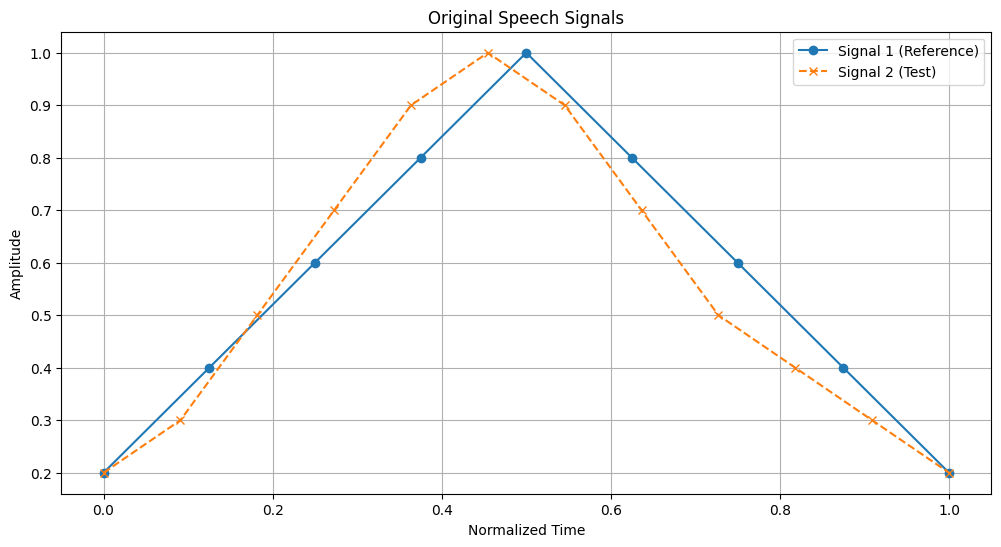

In [17]:
time_signal_1 = np.linspace(0, 1, len_signal_1)
time_signal_2 = np.linspace(0, 1, len_signal_2)

plt.figure(figsize=(12, 6))
plt.plot(time_signal_1, signal_1, label="Signal 1 (Reference)", marker='o')
plt.plot(time_signal_2, signal_2, label="Signal 2 (Test)", marker='x', linestyle='--')
plt.title("Original Speech Signals")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## (b) Perform Linear Time Normalization


Linear Time Normalization adjusts the longer signal by resampling it to match the length of the shorter signal.

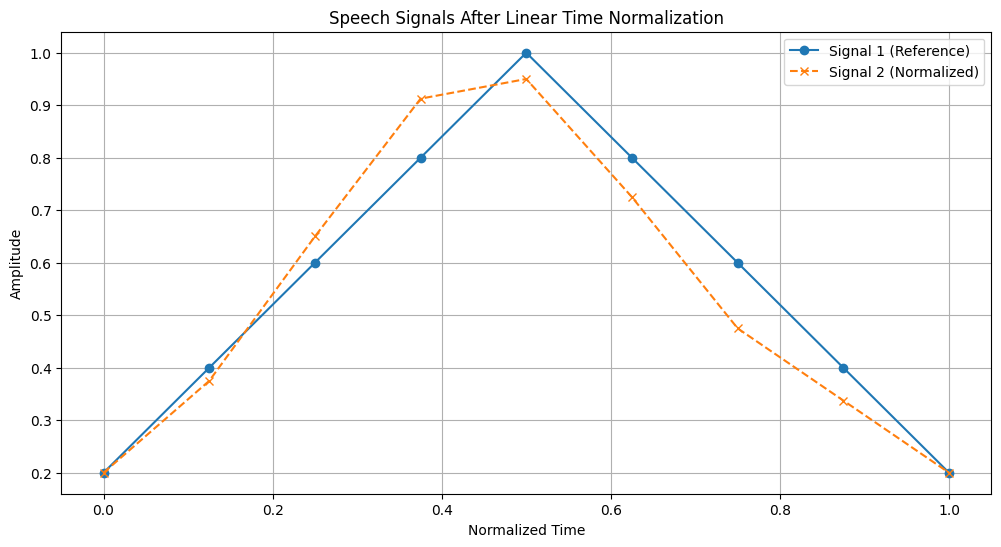

In [18]:
time_signal_2_normalized = np.linspace(0, ZS1, len_signal_1)  # Normalized to match length of Signal 1
interp_func = interp1d(time_signal_2, signal_2, kind='linear')  # Linear interpolation
signal_2_normalized = interp_func(time_signal_2_normalized)

# Plot normalized signals
plt.figure(figsize=(12, 6))
plt.plot(time_signal_1, signal_1, label="Signal 1 (Reference)", marker='o')
plt.plot(time_signal_2_normalized, signal_2_normalized, label="Signal 2 (Normalized)", marker='x', linestyle='--')
plt.title("Speech Signals After Linear Time Normalization")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## (c) Compute alignment

In [24]:
alignment_cost = np.sum((signal_1 - signal_2_normalized)**2) / len_signal_1
print(f"Alignment Cost between Signal 1 and normalized Signal 2 (MSE): {alignment_cost}")

Alignment Cost between Signal 1 and normalized Signal 2 (MSE): 0.00482638888888889


## (d) Plot the alignment path

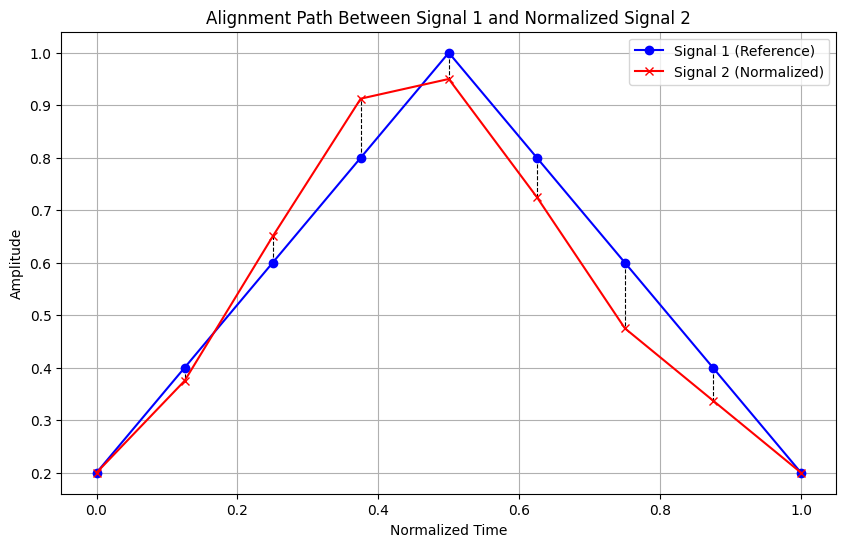

In [20]:
plt.figure(figsize=(10, 6))
for i in range(len_signal_1):
    plt.plot([i / (len_signal_1 - 1), i / (len_signal_1 - 1)],
             [signal_1[i], signal_2_normalized[i]], 'k--', linewidth=0.8)

# Overlay signals for reference
plt.plot(np.linspace(0, 1, len_signal_1), signal_1, 'bo-', label="Signal 1 (Reference)")
plt.plot(np.linspace(0, 1, len_signal_1), signal_2_normalized, 'rx-', label="Signal 2 (Normalized)")

plt.title("Alignment Path Between Signal 1 and Normalized Signal 2")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# (e) Linear Time Normalization


LTN rescaled Signal 2 to match the length of Signal 1.
The alignment cost 0.0048 indicates the signals are closely aligned.
LTN assumes uniform stretching, so it works well for this example but may fail in cases with non-linear variations.

## 2. Dynamic Time Warping (DTW)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Define the vectors
vector_1 = np.array([2, 3, 4, 6, 8, 7, 6, 5, 4, 3, 2])
vector_2 = np.array([2, 4, 6, 7, 7, 6, 5, 5, 4, 3, 2, 2, 1])

## (a) Plot both vectors

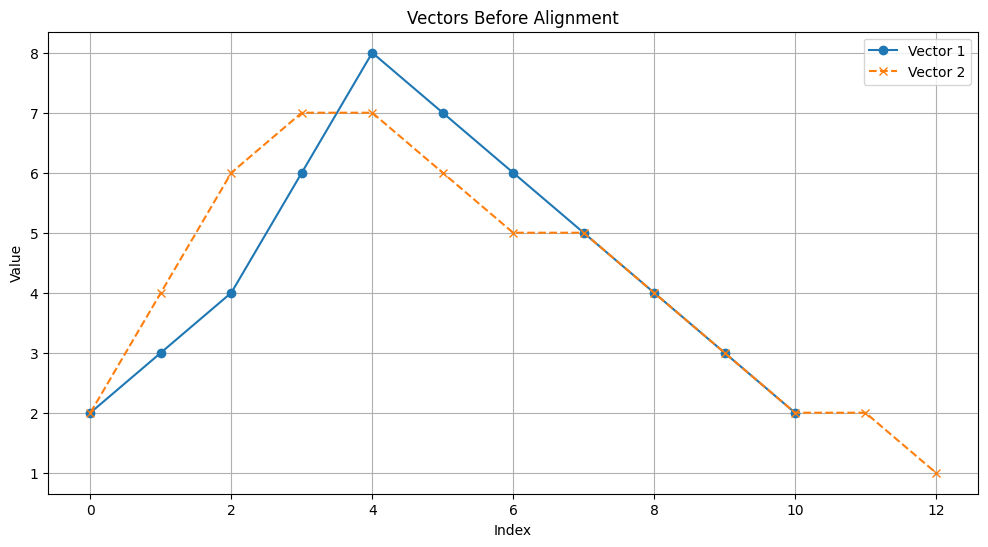

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(vector_1)), vector_1, label="Vector 1", marker='o')
plt.plot(range(len(vector_2)), vector_2, label="Vector 2", marker='x', linestyle='--')
plt.title("Vectors Before Alignment")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## (b) Implement Dynamic Time Warping (DTW) algorithm

In [28]:
def compute_dtw(v1, v2):
    n, m = len(v1), len(v2)
    cost_matrix = np.zeros((n, m))

    # Initialize the cost matrix
    cost_matrix[0, 0] = abs(v1[0] - v2[0])
    for i in range(1, n):
        cost_matrix[i, 0] = cost_matrix[i-1, 0] + abs(v1[i] - v2[0])
    for j in range(1, m):
        cost_matrix[0, j] = cost_matrix[0, j-1] + abs(v1[0] - v2[j])

    # Fill the rest of the cost matrix
    for i in range(1, n):
        for j in range(1, m):
            cost = abs(v1[i] - v2[j])
            cost_matrix[i, j] = cost + min(cost_matrix[i-1, j],  # Insertion
                                           cost_matrix[i, j-1],  # Deletion
                                           cost_matrix[i-1, j-1])  # Match

    return cost_matrix

# Compute the accumulated cost matrix
cost_matrix = compute_dtw(vector_1, vector_2)

## (c) Visualize the accumulated cost matrix

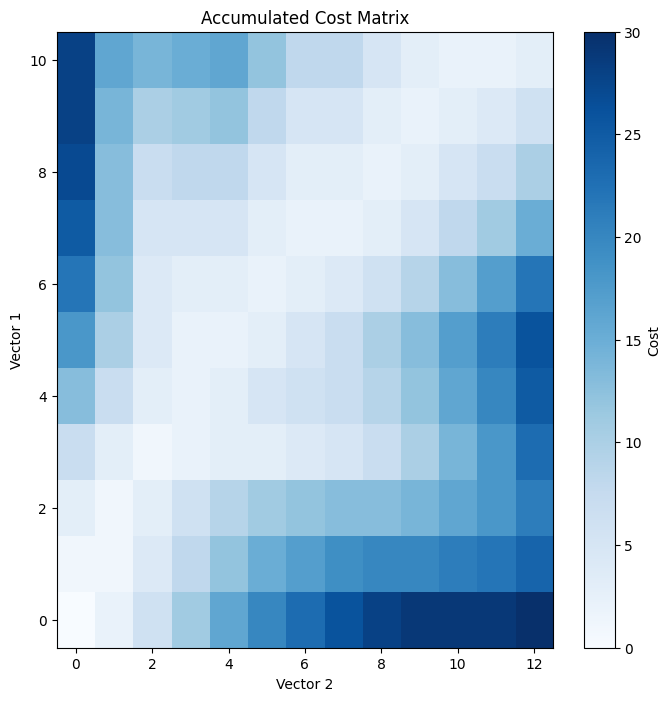

In [29]:
plt.figure(figsize=(8, 8))
plt.imshow(cost_matrix, origin='lower', cmap='Blues', aspect='auto')
plt.colorbar(label="Cost")
plt.title("Accumulated Cost Matrix")
plt.xlabel("Vector 2")
plt.ylabel("Vector 1")
plt.grid(False)
plt.show()

## (d) Find and visualize the warping path

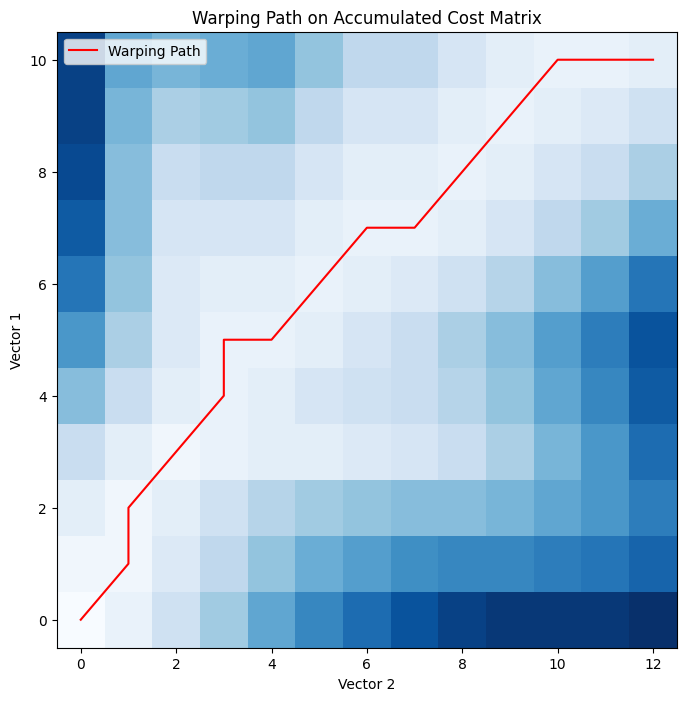

In [30]:
def compute_warping_path(cost_matrix):
    i, j = np.array(cost_matrix.shape) - 1
    path = [(i, j)]

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            steps = [cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1]]
            min_step = np.argmin(steps)
            if min_step == 0:
                i -= 1
            elif min_step == 1:
                j -= 1
            else:
                i -= 1
                j -= 1
        path.append((i, j))

    return path[::-1]  # Reverse the path to start from (0,0)

# Compute the warping path
warping_path = compute_warping_path(cost_matrix)

# Plot the warping path on the cost matrix
plt.figure(figsize=(8, 8))
plt.imshow(cost_matrix, origin='lower', cmap='Blues', aspect='auto')
path_x, path_y = zip(*warping_path)
plt.plot(path_y, path_x, color='red', label='Warping Path')
plt.title("Warping Path on Accumulated Cost Matrix")
plt.xlabel("Vector 2")
plt.ylabel("Vector 1")
plt.legend()
plt.grid(False)
plt.show()

## (e) Calculate the DTW distance

In [31]:
dtw_distance = cost_matrix[-1, -1]
print(f"DTW Distance: {dtw_distance}")

DTW Distance: 3.0


# (f) Inference

1. The warping path aligns the two vectors by stretching and shifting elements to minimize the overall distance.
2. The DTW distance is 3.0, indicating the similarity between the two vectors.
3. A lower DTW distance suggests higher similarity, even though Vector 2 is stretched and slightly shifted compared to Vector 1.